# Classification: Deep Learning

In diesem Notebook verwenden wir Neuronale Netze um die Klassifizierung in "Failure" / "No Failure " durchzuführen.

In [48]:
import glob
import os
os.environ['KERAS_BACKEND'] = 'theano' # Because tensorflow don't work on my machine
#os.environ['THEANO_FLAGS'] = "device=cuda,force_device=True,floatX=float32"
os.environ['MKL_NUM_THREADS'] = '12'
os.environ['GOTO_NUM_THREADS'] = '12'
os.environ['OMP_NUM_THREADS'] = '12'
os.eviron['openmp'] = 'True'
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.model_selection import train_test_split
from Evaluator import Evaluator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn import metrics
from sklearn.metrics import classification_report
import Helpers
import numpy as np
import Preprocessing as pp
pd.options.mode.chained_assignment = None  # default='warn'

epochs = 180
evaluator = Evaluator()

# Path of the dataset, load data and labels using generator method
# (Generator combines folders with multiple data CSV files to one numpy array and finds corresponding label for each CSV)
path_data = '/Users/marvinwoller/Desktop/SmartDataAnalytics/Blatt2/data/'
path_train = path_data + 'resampled/resampled_12H/mean/'
path_test = path_data + 'resampled_test/resampled_12H/mean/'

feature_path = path_data + 'features/'
feature_path_test = path_data + 'features_test/'

resampled_path = path_data + 'resampled/'
resampled_path_test = path_data + 'resampled_test/'

AttributeError: module 'os' has no attribute 'eviron'

In [ ]:
# Load data
#data, labels = Helpers.data_label_generator_for_resampled_data(path=path_train)

In [ ]:
#data_test, labels_test = Helpers.data_label_generator_for_resampled_data(path=path_test, train_or_test='test')

In [ ]:
"""
# define the keras model
model = Sequential()
model.add(Dense(64, input_dim = 72, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

# split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.4, random_state=2, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

#Callback definition
#earlystop = EarlyStopping(patience=10)
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
#callbacks = [earlystop, learning_rate_reduction]

# fit the keras model on the dataset
#history = model.fit(X, y, validation_split=0.1, shuffle=True, epochs=500, batch_size=512, verbose=1)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=1024, verbose=0, validation_data=[X_val, y_val])

evaluator.predict(model, X_test, y_test)
#evaluator.saveModel(model,"DNN")
evaluator.evaluateACC(history)
evaluator.evaluateROC()
evaluator.evaluateAUC()
evaluator.evaluateCM()
evaluator.others()

evaluator.predict(model, data_test, labels_test)
#evaluator.evaluateACC(history)
evaluator.evaluateROC()
evaluator.evaluateAUC()
evaluator.evaluateCM()
evaluator.others()

del evaluator, model
"""

In [36]:
# Define the Model
def make_model(input_dim=72):
    model = Sequential()
    model.add(Dense(64, input_dim = input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

    return model

def classification(X_train,y_train,X_test,y_test,name,eval=False):
    # Split train data to get a second test set without concept drift
    X_train, X_test_trainset, y_train, y_test_trainset = train_test_split(X_train, y_train, test_size=0.2, random_state=123)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    # Create the model
    model = make_model(input_dim=len(X_train[0])) # Set input dimension, this may change depending on preprocessing
    # Fit the classifier
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=1024, verbose=0, validation_data=[X_val, y_val])

    # Perform prediction on 20% train set data (no drift)
    y_pred_trainset = model.predict(X_test_trainset) > 0.5
    # Perform prediction on test data (with drift)
    y_pred = model.predict(X_test) > 0.5
    print("##################### " + name + " #####################")
    print("---------------- TRAIN ----------------")
    print("TRAIN Accuracy (" + name + "):",metrics.accuracy_score(y_test_trainset, y_pred_trainset))
    #print(classification_report(y_test_trainset, y_pred_trainset))
    print("---------------- TEST ----------------")
    print("TEST Accuracy (" + name + "):",metrics.accuracy_score(y_test, y_pred))
    #print(classification_report(y_test, y_pred))
    if eval:
        evaluate(model,history,X_test_trainset,y_test_trainset,X_test,y_test)
    del model

def evaluate(model, history, X_test_trainset, y_test_trainset, X_test, y_test):
    evaluator.predict(model, X_test_trainset, y_test_trainset)
    #evaluator.saveModel(model,"DNN")
    evaluator.evaluateACC(history)
    evaluator.evaluateROC()
    evaluator.evaluateAUC()
    evaluator.evaluateCM()
    evaluator.others()

    evaluator.predict(model, X_test, y_test)
    #evaluator.evaluateACC(history)
    evaluator.evaluateROC()
    evaluator.evaluateAUC()
    evaluator.evaluateCM()
    evaluator.others()

# Use extracted Features for classification
features = ['mean', 'median', 'min', 'max', 'std', 'var']
features2 = ['std', 'var']

resamples = ['resampled_12H_mean','resampled_12H_median','resampled_6H_median','resampled_3H_mean','resampled_3H_median']

## Feature Daten

In [11]:
# Preprocessing: Remove strong drift + scaling
for feature in features:
    df = pd.read_csv(feature_path + feature + '.csv', index_col=0)
    df_test = pd.read_csv(feature_path_test + feature + '.csv', index_col=0)
    y_train, X_train = pp.preprocess(df, random_n=len(df), rem_drift=False)
    y_test, X_test = pp.preprocess_test(df_test, rem_drift=False)
    classification(X_train,y_train,X_test,y_test,feature)

##################### mean #####################
---------------- TRAIN ----------------
TRAIN Accuracy (mean): 0.863009592326139
---------------- TEST ----------------
TEST Accuracy (mean): 0.5257043664040593
##################### median #####################
---------------- TRAIN ----------------
TRAIN Accuracy (median): 0.8529676258992805
---------------- TEST ----------------
TEST Accuracy (median): 0.5046067565763119
##################### min #####################
---------------- TRAIN ----------------
TRAIN Accuracy (min): 0.7553956834532374
---------------- TEST ----------------
TEST Accuracy (min): 0.519428495126185
##################### max #####################
---------------- TRAIN ----------------
TRAIN Accuracy (max): 0.8673561151079137
---------------- TEST ----------------
TEST Accuracy (max): 0.49225530778475096
##################### std #####################
---------------- TRAIN ----------------
TRAIN Accuracy (std): 0.7585431654676259
---------------- TEST ------

Dadurch, dass wir nun ein neuronales Netz verwenden, um die Klassifizierung durchzuführen, konnten wir dir Accuracy Werte zumindest für bekannte Daten im Gegensatz zur SVM stark verbessern. Der Beste Accuracy Wert den wir mit dem neuronalen Netz auf den feature Daten erreichen konnten war für das feature mean ein Wert von 0.85 für Daten ohne drift (test set) und 0.526 für Daten mit Drift. Das neuronale Netz wird also auch stark von dem concept drift beeinträchtigt.

Im folgenden betrachten wir das mean feature noch einmal genauer:

##################### var #####################
---------------- TRAIN ----------------
TRAIN Accuracy (var): 0.6785071942446043
---------------- TEST ----------------
TEST Accuracy (var): 0.4949926558953131


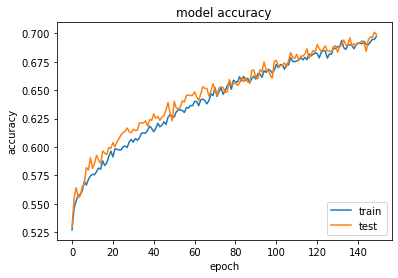

YVal: 0.011349693251533743


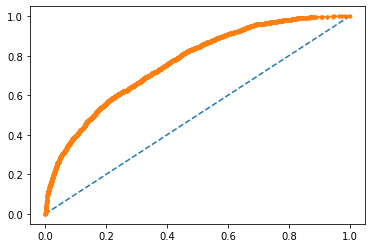

AUC: 0.764


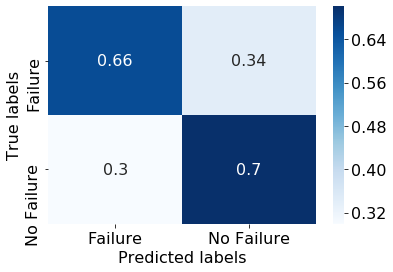

FP: 1169.000000001
FN: 976.000000001
TP: 2284.000000001
TN: 2243.000000001
TPR: 0.7006134969323923
TNR: 0.6573856975380086
PPV: 0.6614538082825593
NPV: 0.6968002485242641
FAR: 0.3426143024619914
FRR: 0.2993865030676077
FDR: 0.33854619171744077
YVal: 0.0010492042509961175


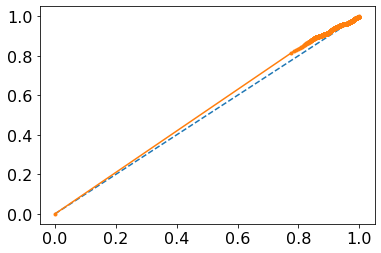

AUC: 0.520


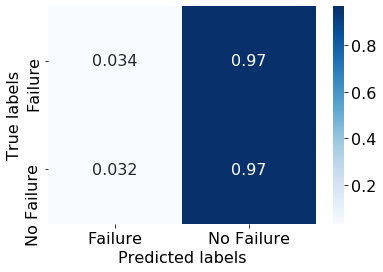

FP: 7327.000000001
FN: 237.000000001
TP: 7159.000000001
TN: 255.000000001
TPR: 0.967955651703497
TNR: 0.03363228699563871
PPV: 0.49420129780477784
NPV: 0.5182926829267549
FAR: 0.9663677130043612
FRR: 0.032044348296502954
FDR: 0.5057987021952222


In [14]:
df = pd.read_csv(feature_path + feature + '.csv', index_col=0)
df_test = pd.read_csv(feature_path_test + 'mean' + '.csv', index_col=0)
y_train, X_train = pp.preprocess(df, random_n=len(df), rem_drift=False)
y_test, X_test = pp.preprocess_test(df_test, rem_drift=False)
classification(X_train, y_train, X_test, y_test, feature, eval=True)

Die Ergebnisse sind so noch nicht zufriedenstellend.
Wir versuchen nun die Ergebnisse zu verbessern, indem wir bekannte Variablen mit starkem Drift entfernen. Es wird erneut das mean feature betrachtet.

##################### mean #####################
---------------- TRAIN ----------------
TRAIN Accuracy (mean): 0.8210431654676259
---------------- TEST ----------------
TEST Accuracy (mean): 0.5196287888903726


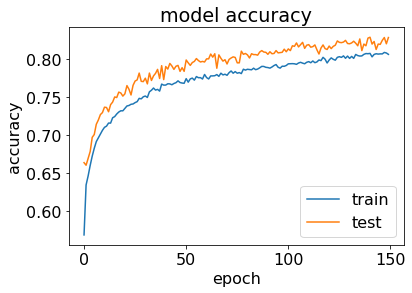

YVal: 0.28773006134969326


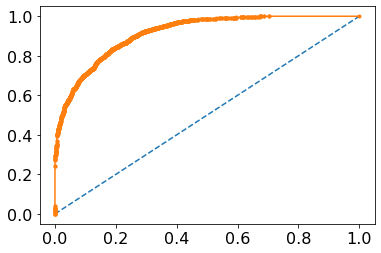

AUC: 0.915


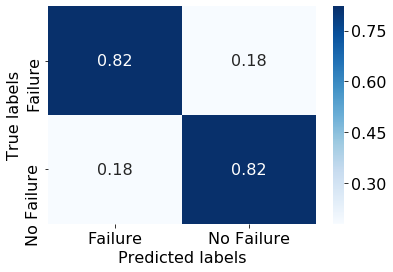

FP: 609.000000001
FN: 585.000000001
TP: 2675.000000001
TN: 2803.000000001
TPR: 0.8205521472390671
TNR: 0.8215123094957084
PPV: 0.8145554202190533
NPV: 0.8273317591497478
FAR: 0.1784876905042916
FRR: 0.17944785276093286
FDR: 0.18544457978094675
YVal: 0.0


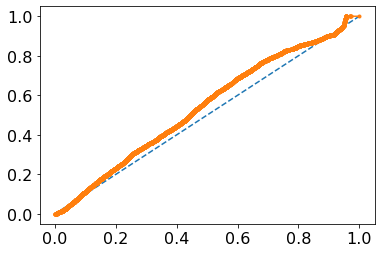

AUC: 0.543


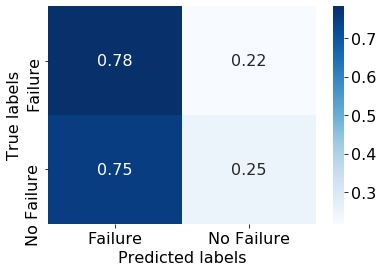

FP: 1652.000000001
FN: 5543.000000001
TP: 1853.000000001
TN: 5930.000000001
TPR: 0.2505408328827067
TNR: 0.7821155367976043
PPV: 0.5286733238230935
NPV: 0.5168656846509166
FAR: 0.21788446320239568
FRR: 0.7494591671172932
FDR: 0.47132667617690654


In [30]:
df = pd.read_csv(feature_path + 'mean' + '.csv', index_col=0)
df_test = pd.read_csv(feature_path_test + 'mean' + '.csv', index_col=0)
y_train, X_train = pp.preprocess(df, random_n=len(df), rem_drift=True)
y_test, X_test = pp.preprocess_test(df_test, rem_drift=True)
classification(X_train, y_train, X_test, y_test, 'mean', eval=True)

Das Entfernen der Variablen mit starkem drift hat das Ergebnis leicht verbessert. Die Vorhersage mit Daten aus dem test set liefert dennoch schlechte Werte.

In [34]:
df = pd.read_csv(feature_path + 'mean' + '.csv', index_col=0)
df_test = pd.read_csv(feature_path_test + 'mean' + '.csv', index_col=0)
y_train, X_train = pp.preprocess(df, random_n=len(df), rem_drift=True, rem_corr=True)
y_test, X_test = pp.preprocess_test(df_test, rem_drift=True, rem_corr=True)
classification(X_train, y_train, X_test, y_test, 'mean', eval=False)

KeyError skipping...
KeyError skipping...
KeyError skipping...
KeyError skipping...
KeyError skipping...
KeyError skipping...
KeyError skipping...
KeyError skipping...
KeyError skipping...
KeyError skipping...
##################### mean #####################
---------------- TRAIN ----------------
TRAIN Accuracy (mean): 0.8187949640287769
---------------- TEST ----------------
TEST Accuracy (mean): 0.511817332087061


## Zeitreihen
Wir versuchen nun direkt mit den (gekürzten) Zeitreihendaten zu arbeiten.

In [37]:
for resample in resamples:
    df = pd.read_csv(resampled_path + resample + '.csv', index_col=0)
    df_test = pd.read_csv(resampled_path_test + resample + '.csv', index_col=0)
    y_train, X_train = pp.preprocess(df, random_n=len(df), rem_drift=False)
    y_test, X_test = pp.preprocess_test(df_test, rem_drift=False)
    classification(X_train,y_train,X_test,y_test,resample)

##################### var #####################
---------------- TRAIN ----------------
TRAIN Accuracy (var): 0.9221549234583046
---------------- TEST ----------------
TEST Accuracy (var): 0.5139627886839316
##################### var #####################
---------------- TRAIN ----------------
TRAIN Accuracy (var): 0.9352398476833039
---------------- TEST ----------------
TEST Accuracy (var): 0.5310531053105311
##################### var #####################
---------------- TRAIN ----------------
TRAIN Accuracy (var): 0.9463948612043735
---------------- TEST ----------------
TEST Accuracy (var): 0.5043744605960097
##################### var #####################
---------------- TRAIN ----------------
TRAIN Accuracy (var): 0.8460732521664489
---------------- TEST ----------------
TEST Accuracy (var): 0.5175267401077748
##################### var #####################
---------------- TRAIN ----------------
TRAIN Accuracy (var): 0.8771577704984252
---------------- TEST ----------------


Das Beste Ergebnis erzielen wir hier mit den 6H Median Daten. Die Ergebnisse der Zeitreihendaten sind im Allgemeinen besser als die der feature Daten.
Wir betrachten daher die Zeitreihendaten genauer und fokusieren uns auf den 6H Median Datensatz.

##################### resampled_6H_median #####################
---------------- TRAIN ----------------
TRAIN Accuracy (resampled_6H_median): 0.9474971176627095
---------------- TEST ----------------
TEST Accuracy (resampled_6H_median): 0.5185893422232751


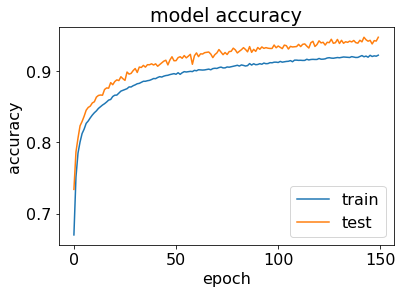

YVal: 0.6176470588235294


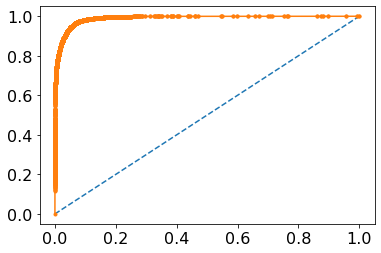

AUC: 0.990


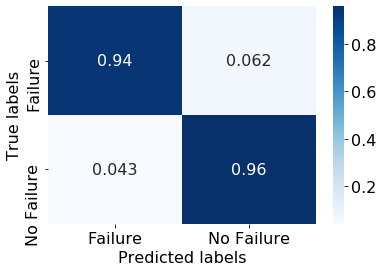

FP: 2484.000000001
FN: 1660.000000001
TP: 36896.000000001004
TN: 37889.000000001004
TPR: 0.9569457412594431
TNR: 0.9384737324449292
PPV: 0.9369222955814913
NPV: 0.9580267516245439
FAR: 0.06152626755507089
FRR: 0.043054258740556954
FDR: 0.06307770441850873
YVal: 0.0026213844003326364


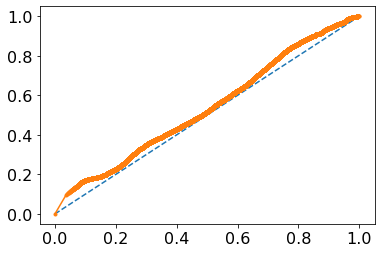

AUC: 0.538


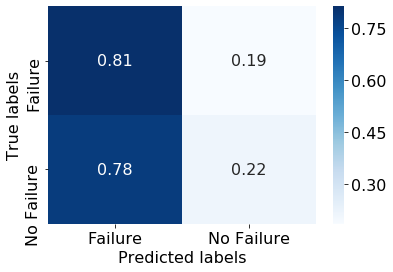

FP: 16747.000000001
FN: 68597.000000001
TP: 18913.000000001
TN: 73022.000000001
TPR: 0.21612387155754276
TNR: 0.8134433935991197
PPV: 0.530370162647222
NPV: 0.5156229037064234
FAR: 0.18655660640088031
FRR: 0.7838761284424572
FDR: 0.4696298373527779


In [38]:
df = pd.read_csv(resampled_path + 'resampled_6H_median' + '.csv', index_col=0)
df_test = pd.read_csv(resampled_path_test + 'resampled_6H_median' + '.csv', index_col=0)
y_train, X_train = pp.preprocess(df, random_n=len(df), rem_drift=False)
y_test, X_test = pp.preprocess_test(df_test, rem_drift=False)
classification(X_train,y_train,X_test,y_test,'resampled_6H_median',eval=True)

Das Modell liefert für bekannte Daten, also für Daten ohne drift, mit einer accuracy von 0.94 und einem AUC-Wert von 0,99 sehr gute Werte.
Die Ergebnisse für den test Datensatz, als für die mit drift behafteten Daten sind leider immernoch sehr schlecht.

Die Einzige Möglichkeit die wir nun sehen um auch auf den Testdaten gute Werte zu bekommen, scheint ein retraining-Ansatz zu sein. In der Praxis würde dieser so aussehen, dass wenn die Daten mit der Zeit (z.B. durch Veränderung der Beschaffenheit der zu Messenden Objekte (data drift)) oder wie in diesem Fall durch hinzufügen neuer Daten aus Quellen, für die eben nicht die gleichen Gesetzmäßigkeiten gelten wie für diese die zum Training der Modelle verwendet wurden (concept drift), verändern, wir diese Daten regelmäßig erfassen und damit das Modell neu trainieren. Das Modell würde somit immer auf den aktuellsten Stand gebracht werden und wäre damit in der Lage die Klassifizierung zufriedenstellend durchzuführen.

Wir versuch an dieser Stelle den Ansatz mit retraining indem wir das bestehende Modell auf den Testdaten erneut trainieren.

In [53]:
df = pd.read_csv(resampled_path + 'resampled_6H_median' + '.csv', index_col=0)
df_test = pd.read_csv(resampled_path_test + 'resampled_6H_median' + '.csv', index_col=0)
y_train, X_train = pp.preprocess(df, random_n=len(df), rem_drift=False)
y_test, X_test = pp.preprocess_test(df_test, rem_drift=False)
#classification(X_train,y_train,X_test,y_test,'resampled_6H_median',eval=True)

# Split train data to get a second test set without concept drift
X_train, X_test_trainset, y_train, y_test_trainset = train_test_split(X_train, y_train, test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# We split the test set into one set for retraining and one set for testing
X_test, X_test_testset, y_test, y_test_testset = train_test_split(X_test, y_test, test_size=0.2, random_state=123)
X_test, X_val_test, y_test, y_val_test = train_test_split(X_test, y_test, test_size=0.1, random_state=42)

# Now append the train and testsets
X_appended_trainset = np.concatenate((X_test , X_train), axis=0)
y_appended_trainset = np.concatenate((y_test , y_train), axis=0)

X_appended_testset = np.concatenate((X_test_trainset , X_test_testset), axis=0)
y_appended_testset = np.concatenate((y_test_trainset , y_test_testset), axis=0)

In [60]:
# Create the model
model = make_model(input_dim=len(X_train[0])) # Set input dimension, this may change depending on preprocessing
# Fit the classifier
epochs = 80
history1 = model.fit(X_train, y_train, epochs=80, batch_size=1024, verbose=0, validation_data=[X_val, y_val])
# Perform prediction before retraining
y_pred_trainset = model.predict(X_test_trainset) > 0.5

# Retrain (using full dataset)
history2 = model.fit(X_appended_trainset, y_appended_trainset, epochs=80, batch_size=1024, verbose=0, validation_data=[X_val_test, y_val_test])
# Perform prediction after retraining
y_pred = model.predict(X_appended_testset) > 0.5

##################### Retrained Model (6H Median Dataset) #####################
---------------- TRAIN ----------------
TRAIN Accuracy (First trained Model): 0.9385523698513855
---------------- TEST ----------------
TEST Accuracy (Retrained Model): 0.9156795034313939


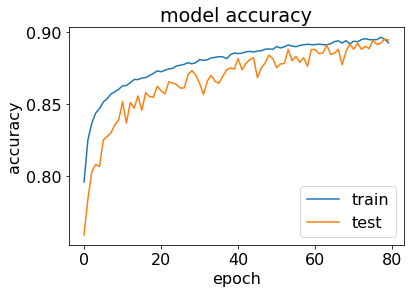

YVal: 0.5206971677559913


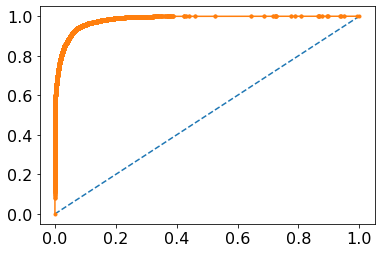

AUC: 0.983


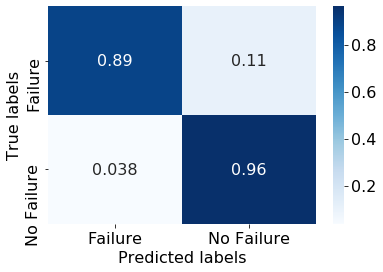

FP: 4342.000000001
FN: 1455.000000001
TP: 37101.000000001004
TN: 36031.000000001004
TPR: 0.9622626828508942
TNR: 0.8924528769226764
PPV: 0.8952295924522647
NPV: 0.9611855092567647
FAR: 0.10754712307732357
FRR: 0.03773731714910583
FDR: 0.1047704075477352


In [58]:
print("##################### " + "Retrained Model (6H Median Dataset)" + " #####################")
print("---------------- TRAIN ----------------")
print("TRAIN Accuracy (" + "First trained Model" + "):",metrics.accuracy_score(y_test_trainset, y_pred_trainset))
#print(classification_report(y_test_trainset, y_pred_trainset))
print("---------------- TEST ----------------")
print("TEST Accuracy (" + "Retrained Model" + "):",metrics.accuracy_score(y_appended_testset, y_pred))

# Evaluation of first trained model
evaluator.predict(model, X_test_trainset, y_test_trainset)
#evaluator.saveModel(model,"DNN")
evaluator.evaluateACC(history2)
evaluator.evaluateROC()
evaluator.evaluateAUC()
evaluator.evaluateCM()
evaluator.others()

YVal: 0.45876866667853267


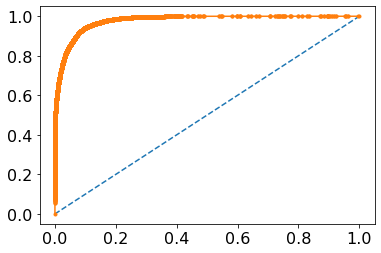

AUC: 0.978


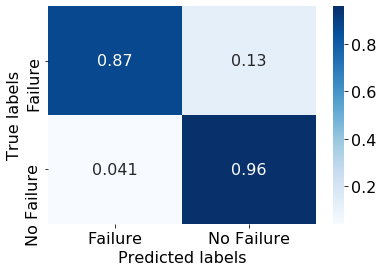

FP: 7342.000000001
FN: 2303.000000001
TP: 53880.000000001004
TN: 50860.000000001004
TPR: 0.959008952886088
TNR: 0.873853132194757
PPV: 0.8800757897487707
NPV: 0.956680398021163
FAR: 0.1261468678052429
FRR: 0.040991047113912
FDR: 0.11992421025122929


In [57]:
evaluator.predict(model, X_appended_testset, y_appended_testset)
#evaluator.saveModel(model,"DNN")
#evaluator.evaluateACC(history2)
evaluator.evaluateROC()
evaluator.evaluateAUC()
evaluator.evaluateCM()
evaluator.others()